# Mahalanobis - Softmax - Trusted for IMDB, Movie Review and MNLI Datasets

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install git+https://github.com/Julien2048/NLP_Project_OOD.git --quiet
!git clone https://github.com/Julien2048/NLP_Project_OOD
!pip install -r NLP_Project_OOD/requirements.txt --quiet

In [ ]:
%cd gdrive/MyDrive/NLP_Project_OOD/distilbert
!rm /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/modeling_distilbert.py
!cp modeling_distilbert.py /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/

!rm /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/__init__.py
!cp __init__.py /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/
%cd ..

%cd transformers
!rm /usr/local/lib/python3.9/dist-packages/transformers/__init__.py
!cp __init__.py /usr/local/lib/python3.9/dist-packages/transformers/
%cd ../../..

In [5]:
from nlp_project.data_loader import IMDBDataset
from nlp_project.OOD_detector import Mahalanobis, MaxSoftmax, IRW, KLDivergence
from nlp_project.metrics import ResultsOOD
from nlp_project.BERT_adaptation import DistilBertClassifier

## Load Classifier

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
model_prelogits = DistilBertClassifier(device=device, prelogits=True, path_pretrained_model="/content/gdrive/MyDrive/NLP_Project_OOD/models_trained/model_imdb_distilbert")
model_hidden_state = DistilBertClassifier(device=device, prelogits=False, path_pretrained_model="/content/gdrive/MyDrive/NLP_Project_OOD/models_trained/model_imdb_distilbert")

In [8]:
imdb_prelogits_train, imdb_logits_train = model_prelogits.load_prelogit_logit("imdb", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
imdb_prelogits_test, imdb_logits_test = model_prelogits.load_prelogit_logit("imdb", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")

movie_review_prelogits_test, movie_review_logits_test = model_prelogits.load_prelogit_logit("movie_review", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
mnli_prelogits_test, mnli_logits_test = model_prelogits.load_prelogit_logit( "mnli", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
sst2_prelogits_test, sst2_logits_test = model_prelogits.load_prelogit_logit( "sst2", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
rte_prelogits_test, rte_logits_test = model_prelogits.load_prelogit_logit( "rte", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")

In [9]:
imdb_hidden_state_train = model_hidden_state.load_hidden_layer("imdb", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
imdb_hidden_state_test = model_hidden_state.load_hidden_layer("imdb", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")

movie_review_hidden_state_test = model_hidden_state.load_hidden_layer("movie_review", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
mnli_hidden_state_test = model_hidden_state.load_hidden_layer("mnli", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
sst2_hidden_state_test = model_hidden_state.load_hidden_layer("sst2", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
rte_hidden_state_test = model_hidden_state.load_hidden_layer("rte", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")

## Computing OOD

### Logits

#### Maximum Softmax

##### IMDB - Movie_review

In [ ]:
softmax_imdb_mr = MaxSoftmax(
    imdb_logits_test,
    movie_review_logits_test,
)
onehots_imdb_mr, scores_imdb_mr = softmax_imdb_mr()
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr, add_to_title="Maximum Softmax: IMDB (in) - Movie Review (out)", plot_several=True)
results_imdb_mr()
softmax_imdb_mr_auroc, softmax_imdb_mr_aupr, softmax_imdb_mr_frp = results_imdb_mr.auroc, results_imdb_mr.aupr, results_imdb_mr.fpr

##### IMDB - MNLI

In [ ]:
softmax_imdb_mnli = MaxSoftmax(
    imdb_logits_test,
    mnli_logits_test,
)

onehots_imdb_mnli, scores_imdb_mnli = softmax_imdb_mnli()
results_imdb_mnli = ResultsOOD(onehots_imdb_mnli, scores_imdb_mnli, add_to_title="Maximum Softmax: IMDB (in) - MNLI (out)", plot_several=True)
results_imdb_mnli()
softmax_imdb_mnli_auroc, softmax_imdb_mnli_aupr, softmax_imdb_mnli_frp = results_imdb_mnli.auroc, results_imdb_mnli.aupr, results_imdb_mnli.fpr

##### IMDB - SST2

In [ ]:
softmax_imdb_sst2 = MaxSoftmax(
    imdb_logits_test,
    sst2_logits_test,
)

onehots_imdb_sst2, scores_imdb_sst2 = softmax_imdb_sst2()
results_imdb_sst2 = ResultsOOD(onehots_imdb_sst2, scores_imdb_sst2, add_to_title="Maximum Softmax: IMDB (in) - SST2 (out)", plot_several=True)
results_imdb_sst2()
softmax_imdb_sst2_auroc, softmax_imdb_sst2_aupr, softmax_imdb_sst2_frp = results_imdb_sst2.auroc, results_imdb_sst2.aupr, results_imdb_sst2.fpr

##### IMDB - RTE

In [ ]:
softmax_imdb_rte = MaxSoftmax(
    imdb_logits_test,
    rte_logits_test,
)

onehots_imdb_rte, scores_imdb_rte = softmax_imdb_rte()
results_imdb_rte = ResultsOOD(onehots_imdb_rte, scores_imdb_rte, add_to_title="Maximum Softmax: IMDB (in) - RTE (out)", plot_several=True)
results_imdb_rte()
softmax_imdb_rte_auroc, softmax_imdb_rte_aupr, softmax_imdb_rte_frp = results_imdb_rte.auroc, results_imdb_rte.aupr, results_imdb_rte.fpr

##### Conclusion

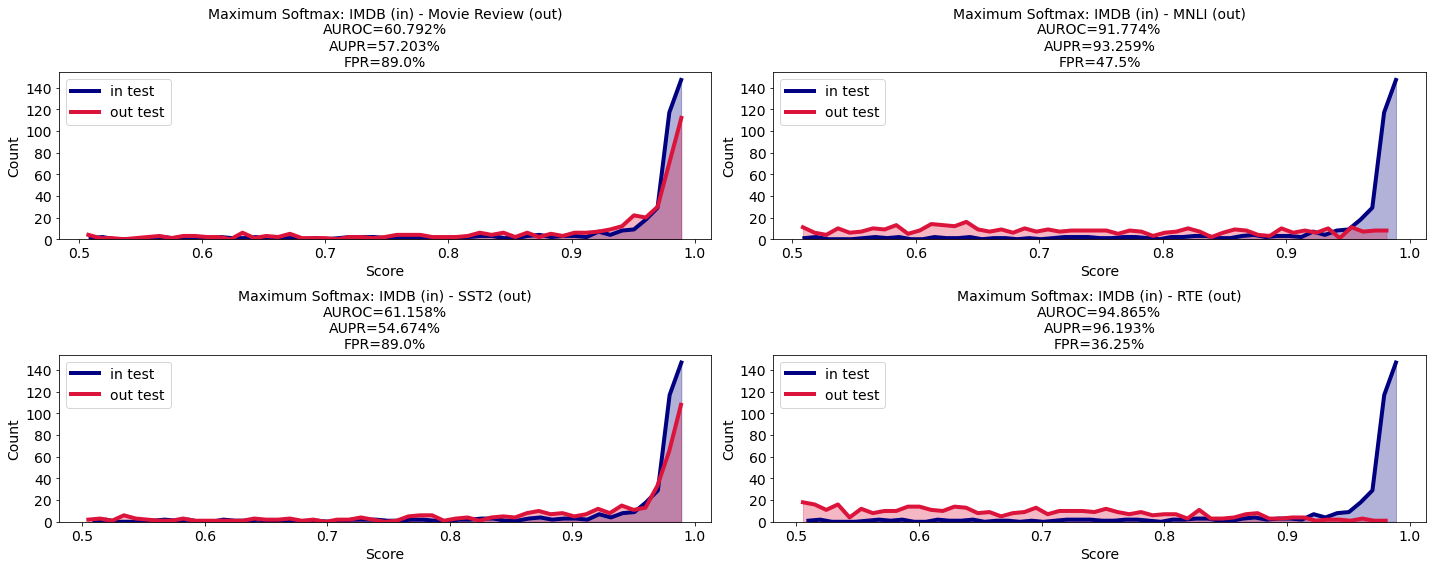

In [54]:
results = [results_imdb_mr, results_imdb_mnli, results_imdb_sst2, results_imdb_rte]
plt.figure(figsize=(20, 8))

for result in results:
    plt.subplot(2, 2, results.index(result)+1)
    result()

#### KL Divergence

##### IMDB - Movie Review

In [ ]:
kl_imdb_mr = KLDivergence(
    imdb_logits_test,
    movie_review_logits_test,
)
onehots_imdb_mr, scores_imdb_mr = kl_imdb_mr()
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr, add_to_title="KL Divergence: IMDB (in) - Movie Review (out)", plot_several=True)
results_imdb_mr()
kl_imdb_mr_auroc, kl_imdb_mr_aupr, kl_imdb_mr_frp = results_imdb_mr.auroc, results_imdb_mr.aupr, results_imdb_mr.fpr

##### IMDB - MNLI

In [ ]:
kl_imdb_mnli = KLDivergence(
    imdb_logits_test,
    mnli_logits_test,
)

onehots_imdb_mnli, scores_imdb_mnli = kl_imdb_mnli()
results_imdb_mnli = ResultsOOD(onehots_imdb_mnli, scores_imdb_mnli, add_to_title="KL Divergence: IMDB (in) - MNLI (out)", plot_several=True)
results_imdb_mnli()
kl_imdb_mnli_auroc, kl_imdb_mnli_aupr, kl_imdb_mnli_frp = results_imdb_mnli.auroc, results_imdb_mnli.aupr, results_imdb_mnli.fpr

IMDB - SST2

In [ ]:
kl_imdb_sst2 = KLDivergence(
    imdb_logits_test,
    sst2_logits_test,
)

onehots_imdb_sst2, scores_imdb_sst2 = kl_imdb_sst2()
results_imdb_sst2 = ResultsOOD(onehots_imdb_sst2, scores_imdb_sst2, add_to_title="KL Divergence: IMDB (in) - SST2 (out)", plot_several=True)
results_imdb_sst2()
kl_imdb_sst2_auroc, kl_imdb_sst2_aupr, kl_imdb_sst2_frp = results_imdb_sst2.auroc, results_imdb_sst2.aupr, results_imdb_sst2.fpr

##### IMDB - RTE

In [ ]:
kl_imdb_rte = KLDivergence(
    imdb_logits_test,
    rte_logits_test,
)

onehots_imdb_rte, scores_imdb_rte = kl_imdb_rte()
results_imdb_rte = ResultsOOD(onehots_imdb_rte, scores_imdb_rte, add_to_title="KL Divergence: IMDB (in) - RTE (out)", plot_several=True)
results_imdb_rte()
kl_imdb_rte_auroc, kl_imdb_rte_aupr, kl_imdb_rte_frp = results_imdb_rte.auroc, results_imdb_rte.aupr, results_imdb_rte.fpr

##### Conclusion

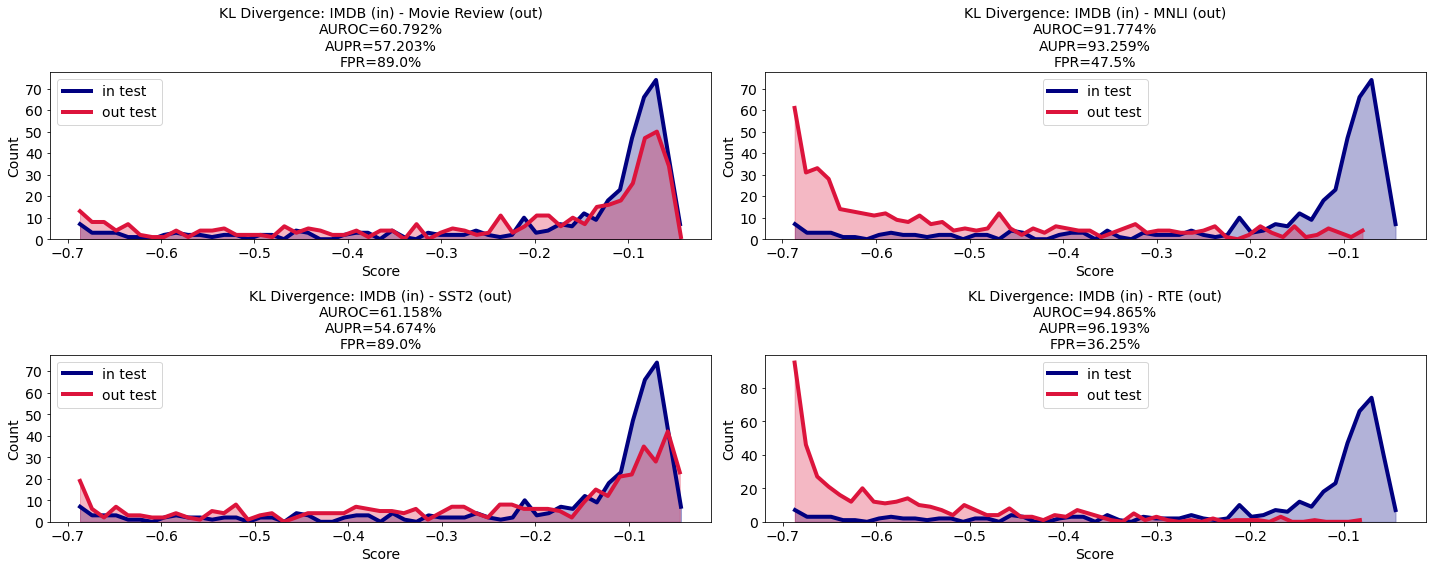

In [59]:
results = [results_imdb_mr, results_imdb_mnli, results_imdb_sst2, results_imdb_rte]
plt.figure(figsize=(20, 8))

for result in results:
    plt.subplot(2, 2, results.index(result)+1)
    result()

### PreLogits

#### Mahalanobis Score

##### IMDB - Movie Review

In [ ]:
get_imdb = IMDBDataset()
imdb_train_labels, imdb_test_labels = get_imdb.load_labels("/content/gdrive/MyDrive/NLP_Project_OOD/data/imdb/")

maha_imdb_mr = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    movie_review_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_mr, scores_imdb_mr = maha_imdb_mr()
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr, add_to_title="Mahalanobis Score: IMDB (in) - Movie Review (out)", plot_several=True)
results_imdb_mr()
maha_imdb_mr_auroc, maha_imdb_mr_aupr, maha_imdb_mr_frp = results_imdb_mr.auroc, results_imdb_mr.aupr, results_imdb_mr.fpr

##### IMDB - MNLI

In [ ]:
maha_imdb_mnli = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    mnli_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_mnli, scores_imdb_mnli = maha_imdb_mnli()
results_imdb_mnli = ResultsOOD(onehots_imdb_mnli, scores_imdb_mnli, add_to_title="Mahalanobis Score: IMDB (in) - MNLI (out)", plot_several=True)
results_imdb_mnli()
maha_imdb_mnli_auroc, maha_imdb_mnli_aupr, maha_imdb_mnli_frp = results_imdb_mnli.auroc, results_imdb_mnli.aupr, results_imdb_mnli.fpr

##### IMDB - SST2

In [ ]:
maha_imdb_sst2 = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    sst2_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_sst2, scores_imdb_sst2 = maha_imdb_sst2()
results_imdb_sst2 = ResultsOOD(onehots_imdb_sst2, scores_imdb_sst2, add_to_title="Mahalanobis Score: IMDB (in) - SST2 (out)", plot_several=True)
results_imdb_sst2()
maha_imdb_sst2_auroc, maha_imdb_sst2_aupr, maha_imdb_sst2_frp = results_imdb_sst2.auroc, results_imdb_sst2.aupr, results_imdb_sst2.fpr

##### IMDB - RTE

In [ ]:
maha_imdb_rte = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    rte_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_rte, scores_imdb_rte = maha_imdb_rte()
results_imdb_rte = ResultsOOD(onehots_imdb_rte, scores_imdb_rte, add_to_title="Mahalanobis Score: IMDB (in) - RTE (out)", plot_several=True)
results_imdb_rte()
maha_imdb_rte_auroc, maha_imdb_rte_aupr, maha_imdb_rte_frp = results_imdb_rte.auroc, results_imdb_rte.aupr, results_imdb_rte.fpr

##### Conclusion

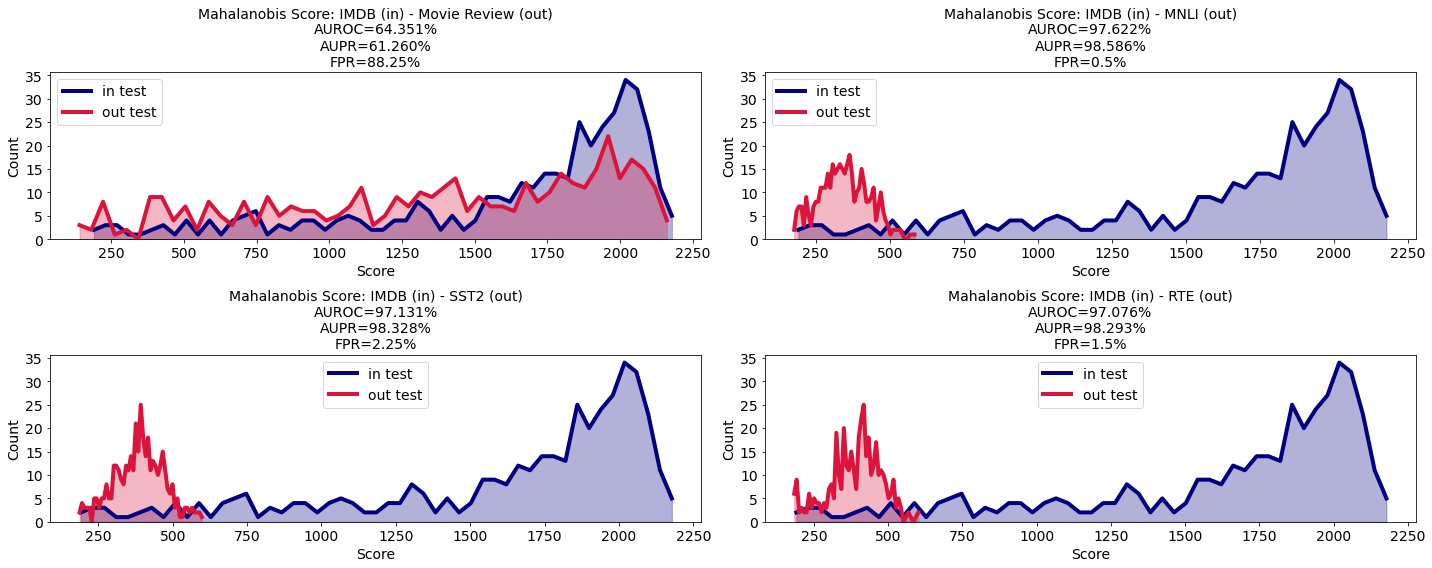

In [49]:
results = [results_imdb_mr, results_imdb_mnli, results_imdb_sst2, results_imdb_rte]
plt.figure(figsize=(20, 8))

for result in results:
    plt.subplot(2, 2, results.index(result)+1)
    result()

### F_PM

#### IRW Score

##### IMDB - Movie Review

In [ ]:
irw_imdb_mr = IRW(
    in_train=imdb_hidden_state_train[:1000],
    in_test=imdb_hidden_state_test[:100],
    out_test=movie_review_hidden_state_test[:100],
    n_dirs=768
)
onehots_imdb_mr, scores_imdb_mr = irw_imdb_mr()
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr, add_to_title="IRW Score: IMDB (in) - Movie Review (out)", plot_several=True)
results_imdb_mr()
irw_imdb_mr_auroc, irw_imdb_mr_aupr, irw_imdb_mr_frp = results_imdb_mr.auroc, results_imdb_mr.aupr, results_imdb_mr.fpr

##### IMDB - MNLI

In [ ]:
irw_imdb_mnli = IRW(
    in_train=imdb_hidden_state_train[:1000],
    in_test=imdb_hidden_state_test[:100],
    out_test=mnli_hidden_state_test[:100],
    n_dirs=768
)
onehots_imdb_mnli, scores_imdb_mnli = irw_imdb_mnli()
results_imdb_mnli = ResultsOOD(onehots_imdb_mnli, scores_imdb_mnli, add_to_title="IRW Score: IMDB (in) - MNLI (out)", plot_several=True)
results_imdb_mnli()
irw_imdb_mnli_auroc, irw_imdb_mnli_aupr, irw_imdb_mnli_frp = results_imdb_mnli.auroc, results_imdb_mnli.aupr, results_imdb_mnli.fpr

##### IMDB - SST2

In [ ]:
irw_imdb_sst2 = IRW(
    in_train=imdb_hidden_state_train[:1000],
    in_test=imdb_hidden_state_test[:100],
    out_test=sst2_hidden_state_test[:100],
    n_dirs=768
)
onehots_imdb_sst2, scores_imdb_sst2 = irw_imdb_sst2()
results_imdb_sst2 = ResultsOOD(onehots_imdb_sst2, scores_imdb_sst2, add_to_title="IRW Score: IMDB (in) - SST2 (out)", plot_several=True)
results_imdb_sst2()
irw_imdb_sst2_auroc, irw_imdb_sst2_aupr, irw_imdb_sst2_frp = results_imdb_sst2.auroc, results_imdb_sst2.aupr, results_imdb_sst2.fpr

##### IMDB - RTE

In [ ]:
irw_imdb_rte = IRW(
    in_train=imdb_hidden_state_train[:1000],
    in_test=imdb_hidden_state_test[:100],
    out_test=rte_hidden_state_test[:100],
    n_dirs=768
)
onehots_imdb_rte, scores_imdb_rte = irw_imdb_rte()
results_imdb_rte = ResultsOOD(onehots_imdb_rte, scores_imdb_rte, add_to_title="IRW Score: IMDB (in) - RTE (out)", plot_several=True)
results_imdb_rte()
irw_imdb_rte_auroc, irw_imdb_rte_aupr, irw_imdb_rte_frp = results_imdb_rte.auroc, results_imdb_rte.aupr, results_imdb_rte.fpr

##### Conclusion

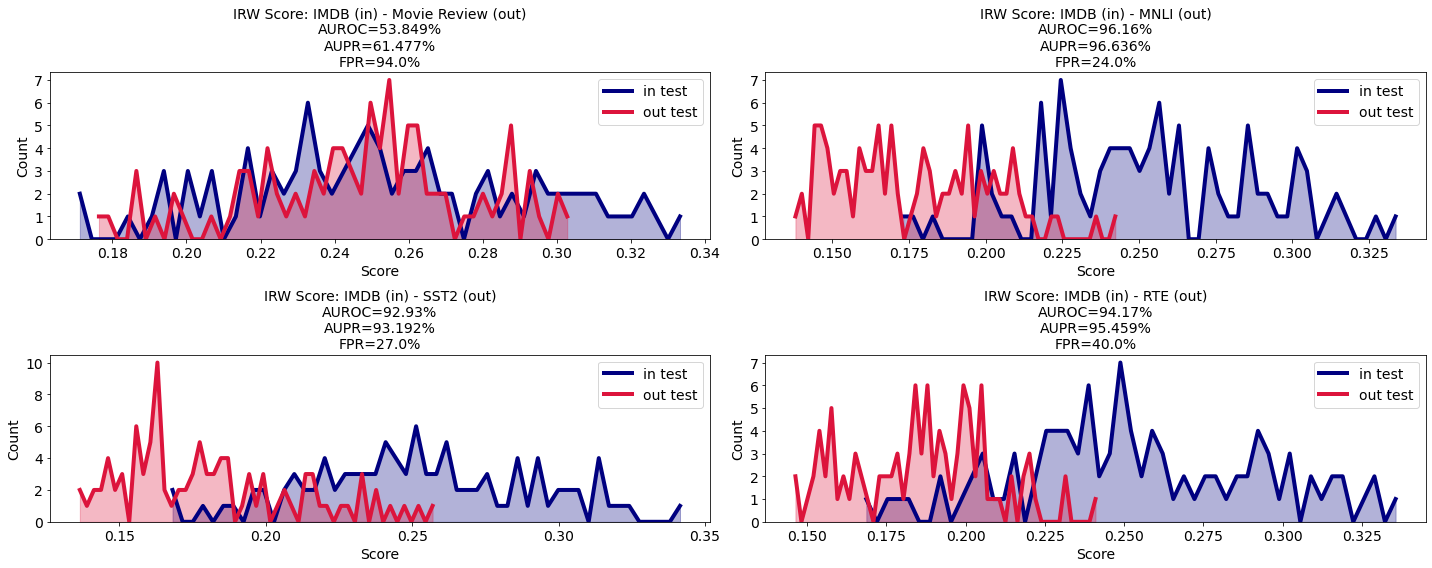

In [40]:
results = [results_imdb_mr, results_imdb_mnli, results_imdb_sst2, results_imdb_rte]
plt.figure(figsize=(20, 8))

for result in results:
    plt.subplot(2, 2, results.index(result)+1)
    result()

### Summary Table

In [63]:
scores = ['MaxSoftmax', 'KL Divergence', 'Mahalanobis', 'IRW']
aggregation = ['Logits', 'Logits', 'Prelogits', 'F_PM']

auroc = [softmax_imdb_mr_auroc, kl_imdb_mr_auroc, maha_imdb_mr_auroc, irw_imdb_mr_auroc]
aupr = [softmax_imdb_mr_aupr, kl_imdb_mr_aupr, maha_imdb_mr_aupr, irw_imdb_mr_aupr]
fpr = [softmax_imdb_mr_frp, kl_imdb_mr_frp, maha_imdb_mr_frp, irw_imdb_mr_frp]

df_mr = pd.DataFrame({'Datasets (out)':['Movie Review']*4, 'Scores':scores, 'Aggregation':aggregation, 'AUROC':auroc, 'AUPR':aupr, 'FPR':fpr})

auroc = [softmax_imdb_mnli_auroc, kl_imdb_mnli_auroc, maha_imdb_mnli_auroc, irw_imdb_mnli_auroc]
aupr = [softmax_imdb_mnli_aupr, kl_imdb_mnli_aupr, maha_imdb_mnli_aupr, irw_imdb_mnli_aupr]
fpr = [softmax_imdb_mnli_frp, kl_imdb_mnli_frp, maha_imdb_mnli_frp, irw_imdb_mnli_frp]

df_mnli = pd.DataFrame({'Datasets (out)':['MNLI']*4, 'Scores':scores, 'Aggregation':aggregation, 'AUROC':auroc, 'AUPR':aupr, 'FPR':fpr})

auroc = [softmax_imdb_sst2_auroc, kl_imdb_sst2_auroc, maha_imdb_sst2_auroc, irw_imdb_sst2_auroc]
aupr = [softmax_imdb_sst2_aupr, kl_imdb_sst2_aupr, maha_imdb_sst2_aupr, irw_imdb_sst2_aupr]
fpr = [softmax_imdb_sst2_frp, kl_imdb_sst2_frp, maha_imdb_sst2_frp, irw_imdb_sst2_frp]

df_sst2 = pd.DataFrame({'Datasets (out)':['SST2']*4, 'Scores':scores, 'Aggregation':aggregation, 'AUROC':auroc, 'AUPR':aupr, 'FPR':fpr})

auroc = [softmax_imdb_rte_auroc, kl_imdb_rte_auroc, maha_imdb_rte_auroc, irw_imdb_rte_auroc]
aupr = [softmax_imdb_rte_aupr, kl_imdb_rte_aupr, maha_imdb_rte_aupr, irw_imdb_rte_aupr]
fpr = [softmax_imdb_rte_frp, kl_imdb_rte_frp, maha_imdb_rte_frp, irw_imdb_rte_frp]

df_rte = pd.DataFrame({'Datasets (out)':['RTE']*4, 'Scores':scores, 'Aggregation':aggregation, 'AUROC':auroc, 'AUPR':aupr, 'FPR':fpr})

df = pd.concat([df_mr, df_mnli, df_sst2, df_rte], axis=0)
df = df.set_index(['Datasets (out)', 'Scores', 'Aggregation'])

def round_two_decimals(x):
    return "{:.1f}%".format(x * 100)

# apply the function to columns 'A' and 'B'
df[['AUROC', 'AUPR', 'FPR']] = df[['AUROC', 'AUPR', 'FPR']].applymap(round_two_decimals)

In [64]:
df

AUROC   AUPR    FPR
Datasets (out) Scores        Aggregation                     
Movie Review   MaxSoftmax    Logits       60.8%  57.2%  89.0%
               KL Divergence Logits       60.8%  57.2%  89.0%
               Mahalanobis   Prelogits    64.4%  61.3%  88.2%
               IRW           F_PM         53.8%  61.5%  94.0%
MNLI           MaxSoftmax    Logits       91.8%  93.3%  47.5%
               KL Divergence Logits       91.8%  93.3%  47.5%
               Mahalanobis   Prelogits    97.6%  98.6%   0.5%
               IRW           F_PM         96.2%  96.6%  24.0%
SST2           MaxSoftmax    Logits       61.2%  54.7%  89.0%
               KL Divergence Logits       61.2%  54.7%  89.0%
               Mahalanobis   Prelogits    97.1%  98.3%   2.2%
               IRW           F_PM         92.9%  93.2%  27.0%
RTE            MaxSoftmax    Logits       94.9%  96.2%  36.2%
               KL Divergence Logits       94.9%  96.2%  36.2%
               Mahalanobis   Prelogits    97.1%  98.3%   1.5%
               IRW           F_PM         94.2%  95.5%  40.0%